# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : Modeling - 2개년도 ML 구축

- y: 23년도 부실기업 여부
- x: 21,22년도 데이터

In [ ]:
pip install numpy pandas scikit-learn xgboost catboost lightgbm optuna matplotlib seaborn

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # StandardScaler 임포트 추가
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import optuna

In [4]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

In [9]:
RANDOM_STATE = 110

data_21to22 = pd.read_csv("project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_21to22.shape)

(27603, 90)


In [13]:
# 종속 변수는 '2023/부실기업'으로 가정
y = data_21to22['2023/부실기업']
X = data_21to22.drop(columns=['2023/부실기업', '업체코드', '종목명'])

# 데이터 분할 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:

# 모델 정의
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

In [16]:
# 하이퍼파라미터 튜닝 함수
def objective(trial, model_name):
    if model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'CatBoost':
        depth = trial.suggest_int('depth', 1, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = CatBoostClassifier(depth=depth, learning_rate=learning_rate, silent=True, random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    else:
        return 0  # 거리 기반 모델은 튜닝하지 않음

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return f1_score(y_test, y_pred, average='weighted')


In [18]:
# 모델 성능 평가 및 시각화
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # SVM과 KNN의 경우 확률 예측을 추가
    if model_name in ['SVM', 'KNN']:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    results[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'model': model
    }


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\core.py:158: UserWarning: [23:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3589, number of negative: 15733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21836
[LightGBM] [Info] Number of data points in the train set: 19322, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.185747 -> initscore=-1.477887
[LightGBM] [Info] Start training from score -1.477887


Random Forest:
  Accuracy: 0.9512
  F1 Score: 0.9525
  ROC AUC: 0.9848

SVM:
  Accuracy: 0.9163
  F1 Score: 0.9138
  ROC AUC: 0.9631

KNN:
  Accuracy: 0.8893
  F1 Score: 0.8837
  ROC AUC: 0.9000

Logistic Regression:
  Accuracy: 0.9012
  F1 Score: 0.8974
  ROC AUC: 0.9525

XGBoost:
  Accuracy: 0.9500
  F1 Score: 0.9511
  ROC AUC: 0.9834

CatBoost:
  Accuracy: 0.9531
  F1 Score: 0.9544
  ROC AUC: 0.9856

LightGBM:
  Accuracy: 0.9533
  F1 Score: 0.9545
  ROC AUC: 0.9849



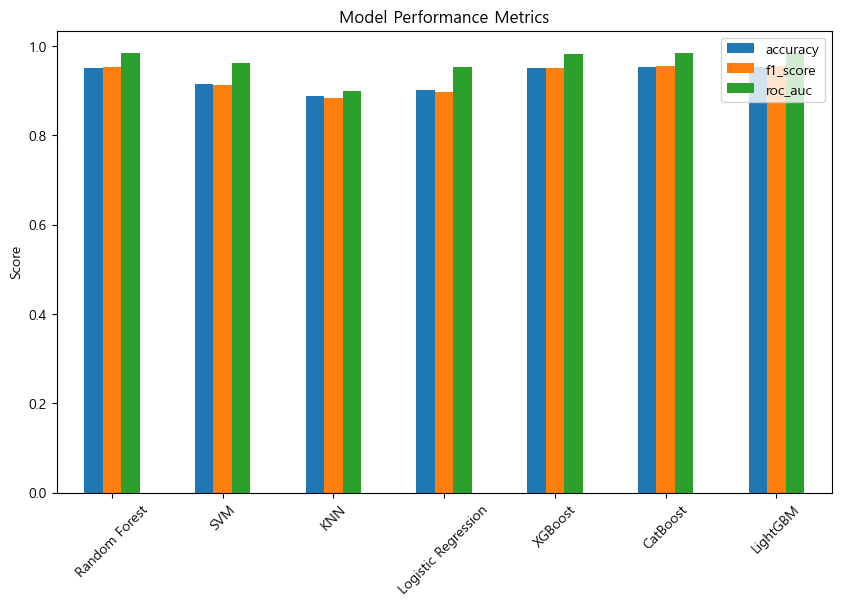

In [21]:
# 성능 지표 시각화 및 출력
metrics_df = pd.DataFrame(results).T

# 각 모델의 성능 지표 출력
for model_name, metrics in metrics_df.iterrows():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")
    print(f"  ROC AUC: {metrics['roc_auc']:.4f}\n")

# 성능 지표 시각화
metrics_df[['accuracy', 'f1_score', 'roc_auc']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

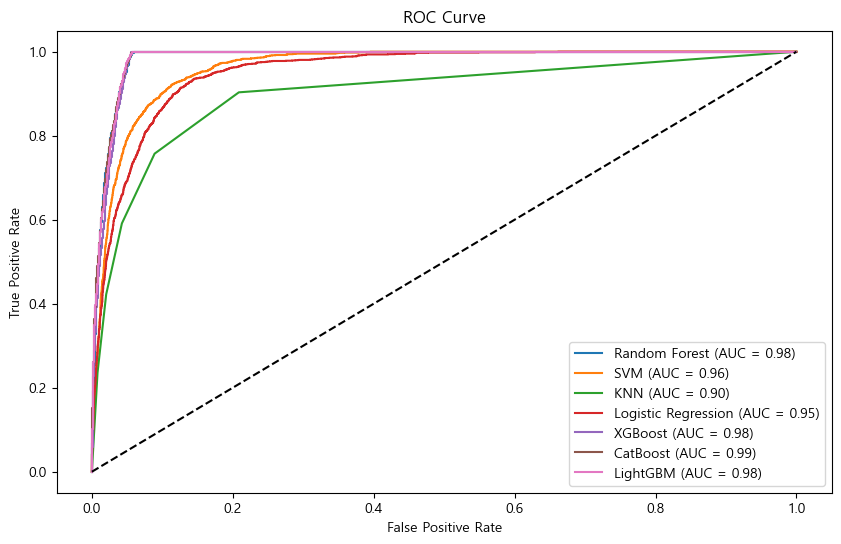

In [20]:
# ROC Curve 시각화
plt.figure(figsize=(10, 6))
for model_name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()